# Predicting Antarctica’s Temperature from NOAA GHCN-D Data using Long Short-Term Memory (LSTM) Networks

-----------------------------------------

## Abstract

Climate trend changes and melting of ice sheets in the Antarctic is of huge interest to researchers, scientists and policymakers. Considering the scale of its impact to the planet and its inhabitants, Antarctic temperatures are being watched closely. This study complements well with this where we predict the minimum and maximum temperatures of the Antarctic using 20-year Global Historical Climatology Network Daily (GHCN-D) data from the National Oceanic and Atmospheric Administration (NOAA). We trained two LSTM models for (1) minimum and (2) maximum temperatures and explored the effect of using one, two and three layers into the prediction performance. All our models’ variations outperformed the baseline model (simple neural network) in terms of mean absolute error (MAE). These models can be used to predict the general trend to which the temperature is heading in Antarctica for the coming years. To capture the more granular trend in the prediction, new variables may be introduced and more architectures and hyperparameters can be explored.

## Introduction

In 1985, scientists at the British Antarctic Survey (BAS) have detected a massive hole in the ozone layer over Antarctica.  This alarming discovery called for a global action to minimize our footprint through human activities and man-made chemicals. Two decades later, the Antarctic ice sheets started losing mass and then accelerated in pace since 2009.  For this, the National Aeronautics and Space Administration (NASA) looks at how changes in the Earth’s climate are affecting the ice sheets, and similarly, how melting of the ice sheets affect the former. If the melting happens on a large scale, the Earth’s climate and sea levels will be immensely affected.

Considering the impact that these phenomena entail, Antarctica then presents a huge area of interest for climate researchers and scientists all over the world. It is therefore imperative that they be able to perform their analysis with greater capability.

Developments in satellite technology enabled for these researchers’ capability to take a closer observation of this continent’s harsh environment. What Antarctic researchers and explorers have been collecting before with great effort are now being captured on a more frequent, e.g. daily or even hourly, basis.

In this study, we look into data generated by these technologies from the National Oceanic and Atmospheric Administration (NOAA) called the Global Historical Climatology Network Daily (GHCN-D) data. We use twenty (20) years’ worth of temperature data from multiple land-based stations scattered in the Antarctic to forecast the continent’s average temperature levels in defined time steps. Using long short-term memory for time series analysis, we explored different hyperparameters to find the optimal values for a high prediction performance.

## Data Collection and Description

The GHCN-D data are stored in the noaa-ghcn-pds s3 bucket given as `s3://noaa-ghcn-pds/csv/`. The s3 bucket is structured by year from 1763 to present, with each file named after the respective year. The data are available in CSV file format so any particular year will be named yyyy.csv. The dataset is updated daily.

Since the data is stored in an s3 bucket, we will be using the `bash terminal` to interface with it. First, we listed the available files inside the s3 bucket by running the command below.

<img src="aws s3 ls.JPG" width=700/>

The above command returns a list of all the available files in `s3://noaa-ghcn-pds/csv/`. A sample is given below.

<img src="listfiles.JPG" width=400/>

Note that the screenshot above is only a portion of the total available files in `s3://noaa-ghcn-pds/csv/`. For the purposes of this report, we will be focusing only on the years 2000 to 2019 (~25GB). 

### Importing the Necessary Libraries

For this analysis, we will be using mostly `dask` to manipulate big data and `pandas` for smaller data. The visualizations will be provided using `matplotlib.pyplot` and `seaborn`. We import the necessary libraries below.

In [2]:
import numpy as np
import pandas as pd
import dask
import dask.array as da
import dask.dataframe as dd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

from dask.distributed import Client
from sklearn.preprocessing import StandardScaler

# Keras imports
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


### Setting up the Dask Cluster

Big data requires a large amount of resources to perform dataframe operations. Dask offers an API to set up multiple machines to run as one cluster. This is provided by the `dask.distributed` API. We set up our cluster to have a total of 4 workers, with each worker having 2 cores and 8GB of RAM. The cluster specs are given below.

In [2]:
client = Client('127.0.0.1:8786')
client

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8080/status,Cluster Workers: 4 Cores: 8 Memory: 33.03 GB


### Loading the NOAA GHCN-D Data

In [3]:
# Create read_csv function
def read_csv(fp):
    noaa = dd.read_csv(fp, delimiter=',', 
                       assume_missing=True, header=None)
    # Rename columns
    noaa.columns = ['Station_ID', 'Date_String', 'Element', 'Data_Value',
                'M_Flag', 'Q_Flag', 'S_Flag', 'Obs_Time']
    return noaa

In [4]:
# Read data
noaa = read_csv(['s3://noaa-ghcn-pds/csv/200*.csv', 's3://noaa-ghcn-pds/csv/201*.csv'])
noaa.head()

,Station_ID,Date_String,Element,Data_Value,M_Flag,Q_Flag,S_Flag,Obs_Time
0,CA002303986,20000101.0,TMAX,-300.0,NaN,NaN,C,NaN
1,CA002303986,20000101.0,TMIN,-345.0,NaN,NaN,C,NaN
2,CA002303986,20000101.0,PRCP,0.0,NaN,NaN,C,NaN
3,CA002303986,20000101.0,SNOW,0.0,NaN,NaN,C,NaN
4,CA002303986,20000101.0,SNWD,120.0,NaN,NaN,C,NaN


The dataframe consists of eight (8) variables, each of which is described below:

 

|#|Variable|Description|
|--|--|--|
|1|**STATION ID**|11 character station identification code|
|2|**DATE**|8 character date in YYYYMMDD format (e.g. 19860529 = May 29, 1986)|
|3|**ELEMENT**|4 character indicator of element type|
|4|**DATA VALUE**|5 character data value for ELEMENT|
|5|**M-FLAG**|1 character Measurement Flag|
|6|**Q-FLAG**|1 character Quality Flag|
|7|**S-FLAG**|1 character Source Flag|
|8|**OBS-TIME**|4-character time of observation in hour-minute format (i.e. 0700 =7:00 am)|

 

The focus of this analysis will be specifically on the TMAX and TMIN elements for all stations in Antarctica. The selection of this data subset is performed in the succeeding section.

## Exploratory Data Analysis (EDA)

The data have been feature engineered and trimmed down to focus on Antarctica's climate data since January 2000. The observations and analysis in the trend over this period are presented in this section.

In [5]:
# Getting number of partitions
noaa.npartitions

407

There are 407 partitions in total for our dataframe. Having this amount of partitions makes it difficult for us to do EDA. So, we create helper functions that filters only the needed data.

In [6]:
# Get data
def get_data(ddf, element, country_code):
    ddf = ddf[(ddf['Element']==element) & (ddf['Station_ID'].str.startswith(country_code))].compute()
    return ddf

In [7]:
# Transform dataframe for specified country
def transform(df):
    df['Date_String'] = df['Date_String'].astype('str')
    df['Year'] = df['Date_String'].apply(lambda x: x[:4])
    df['Month'] = df['Date_String'].apply(lambda x: x[4:6])
    df['Day'] = df['Date_String'].apply(lambda x: x[6:8])
    df['Year'] = df['Year'].astype('int32')
    df['Month'] = df['Month'].astype('int32')
    df['Day'] = df['Day'].astype('int32')
    df['Date'] = df.apply(lambda x: datetime.datetime(x.Year, x.Month, x.Day), 
                              axis=1)
    df = df.drop(['Date_String', 'M_Flag', 'Q_Flag', 'S_Flag', 'Obs_Time'], axis=1)
    return df

### Filtering the Data

We filter the data to include only TMAX, TMIN for Antarctica (AY).

In [8]:
# Getting tmax and tmin for specified country
noaatmax = get_data(noaa, 'TMAX', 'AY')
noaatmin = get_data(noaa, 'TMIN', 'AY')

Looking at the first (2) rows of the max temperature dataframe.

In [9]:
noaatmax.head(2)

,Station_ID,Date_String,Element,Data_Value,M_Flag,Q_Flag,S_Flag,Obs_Time
2328,AYM00088963,20000101.0,TMAX,28.0,NaN,NaN,G,NaN
7878,AYM00089514,20000101.0,TMAX,58.0,NaN,NaN,S,NaN


Looking at the first (2) rows of the minimum temperature dataframe.

In [10]:
noaatmin.head(2)

,Station_ID,Date_String,Element,Data_Value,M_Flag,Q_Flag,S_Flag,Obs_Time
2329,AYM00088963,20000101.0,TMIN,-30.0,NaN,NaN,G,NaN
7673,AYM00089034,20000101.0,TMIN,-125.0,NaN,NaN,S,NaN


Let us then transform the data to retain only the relevant info for our EDA and prediction.

In [11]:
# Transform Dataframe (Retain relevant info)
noaa_tmaxAY = transform(noaatmax)
noaa_tminAY = transform(noaatmin)

Looking at the first (2) rows of the transformed max temperature dataframe.

In [12]:
print(noaa_tmaxAY.shape)
noaa_tmaxAY.head(2)

(130081, 7)


,Station_ID,Element,Data_Value,Year,Month,Day,Date
2328,AYM00088963,TMAX,28.0,2000,1,1,2000-01-01
7878,AYM00089514,TMAX,58.0,2000,1,1,2000-01-01


Looking at the first (2) rows of the transformed minimum temperature dataframe.

In [13]:
print(noaa_tminAY.shape)
noaa_tminAY.head(2)

(136398, 7)


,Station_ID,Element,Data_Value,Year,Month,Day,Date
2329,AYM00088963,TMIN,-30.0,2000,1,1,2000-01-01
7673,AYM00089034,TMIN,-125.0,2000,1,1,2000-01-01


### Maximum and Minimum Temperature through the Years

Now, let's plot the extreme temperatures of Antarctica through the years.

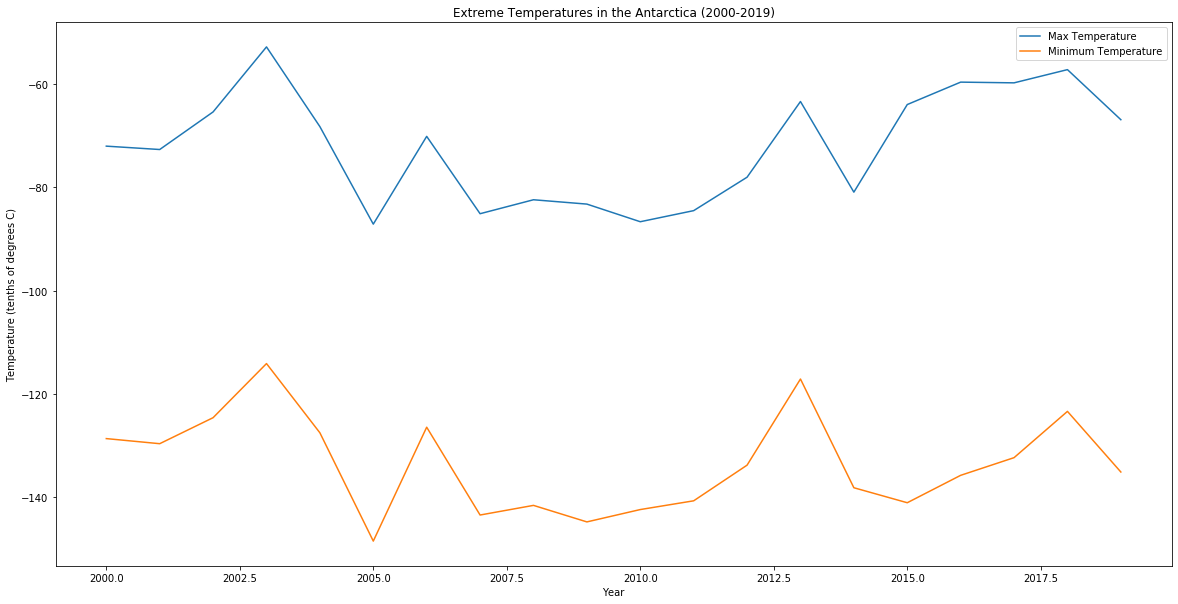

In [14]:
# Plotting tmax and tmin by date
noaa_tmaxAYbydate = noaa_tmaxAY.groupby('Year')['Data_Value'].mean()
noaa_tminAYbydate = noaa_tminAY.groupby('Year')['Data_Value'].mean()

plt.figure(figsize=(20,10))
plt.title('Extreme Temperatures in the Antarctica (2000-2019)')
plt.plot(noaa_tmaxAYbydate.index, noaa_tmaxAYbydate.values, label='Max Temperature')
plt.plot(noaa_tminAYbydate.index, noaa_tminAYbydate.values, label='Minimum Temperature')
plt.xlabel('Year')
plt.ylabel('Temperature (tenths of degrees C)')
plt.legend();

The average maximum and minimum temperatures fluctuate every year, but not too far from a certain level. Temperatures are interestingly levelled from around late 2006 to early 2011, both for the minimum and maximum temperatures. Average temperatures have peaked in late 2002 and dipped in 2005.

These fluctuations could be caused by the number of functioning stations at the time, and also the locations of these stations. It would be interesting to see this trend over a longer period of time to see a more general trend that could be observed. This may not be seen in the current data window since changes in the average temperatures over a large area may only be apparent after decades or even centuries.

### Temperature Distribution per Year

Now, let's look at the temperature distribution of Antarctica per year.

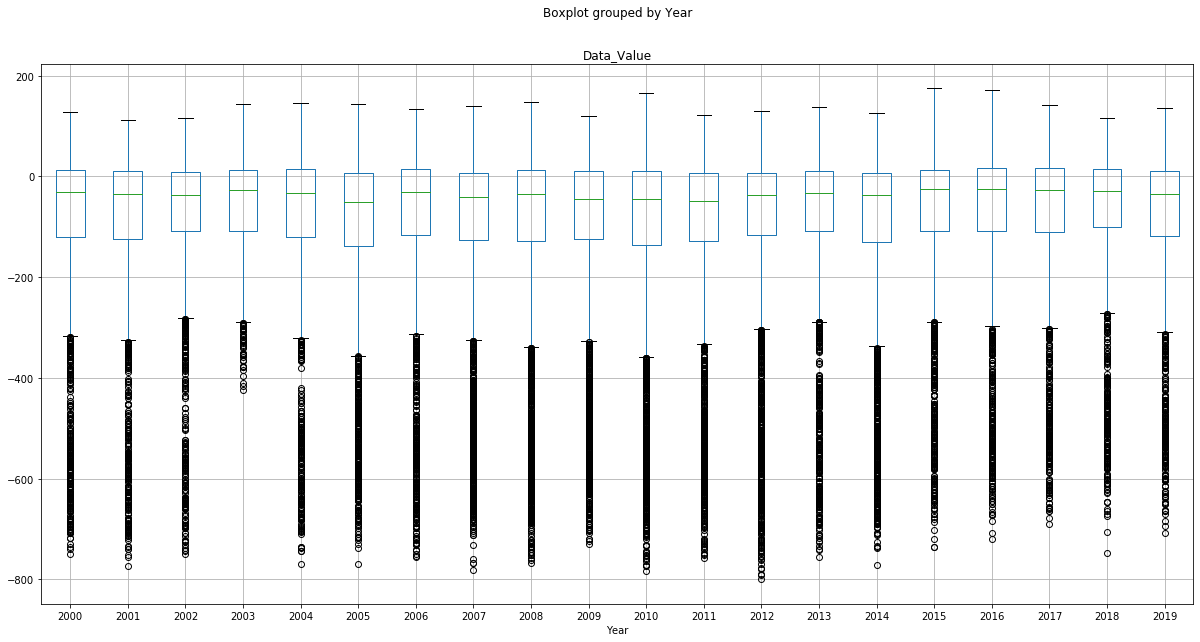

In [15]:
# Distribution of max temperature by year
noaa_tmaxAY.boxplot(column='Data_Value',by='Year', figsize=(20,10))

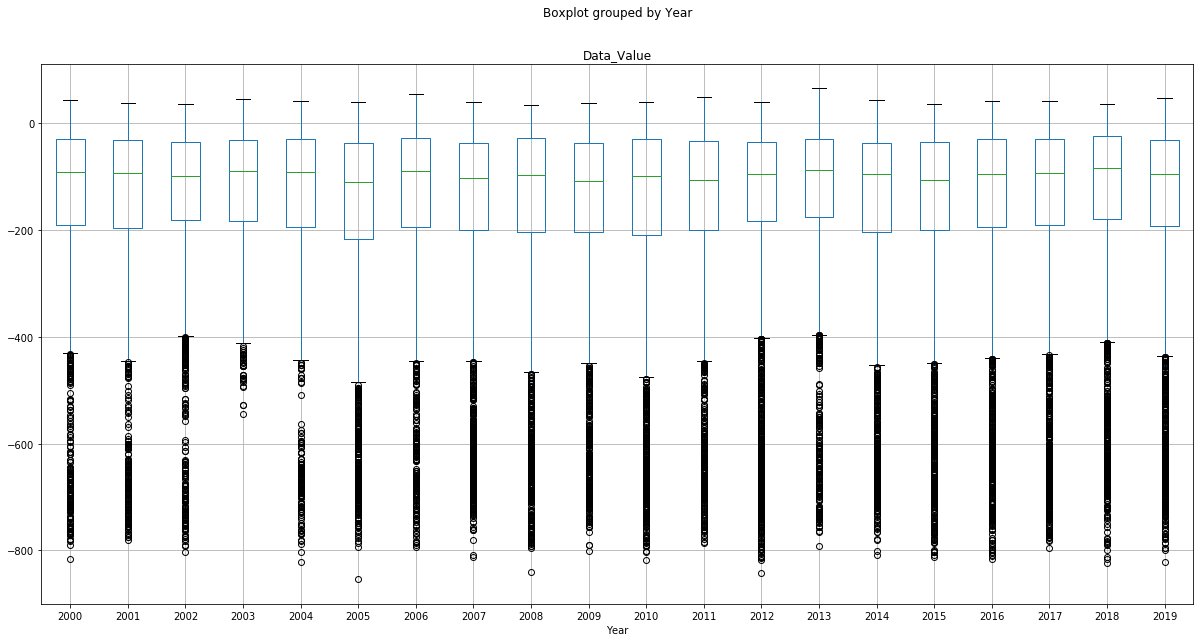

In [16]:
# Distribution of min temperature by year
noaa_tminAY.boxplot(column='Data_Value',by='Year', figsize=(20,10))

Each year reflects relatively similar range of values for the minimum and maximum temperatures. Notably, 2003 sets itself apart from the rest of the years, having the smallest range of values. However, the data does not currently present an explanation for this behavior. A deeper dive into this may be conducted as an extension of this analysis.

### Chloropleth of Temperature per Year-Month

A chloropleth could give us a better look on how the temperatures for Antarctica vary per observation station and across the years. Given below is a chloropleth map of the max temperatures of Antarctica from January 2000 until October 2019.

In [17]:
# Chloropleth map
noaa_tmaxAYhm = noaa_tmaxAY.copy()

noaa_tmaxAYhm['Year'] = noaa_tmaxAYhm['Year'].astype('str')
noaa_tmaxAYhm['Month'] = noaa_tmaxAYhm['Month'].astype('str')

noaa_tmaxAYhm['Year Month'] = noaa_tmaxAYhm['Date'].apply(lambda x: x.strftime('%Y-%m'))
noaa_tmaxAYhm.head(2)

,Station_ID,Element,Data_Value,Year,Month,Day,Date,Year Month
2328,AYM00088963,TMAX,28.0,2000,1,1,2000-01-01,2000-01
7878,AYM00089514,TMAX,58.0,2000,1,1,2000-01-01,2000-01


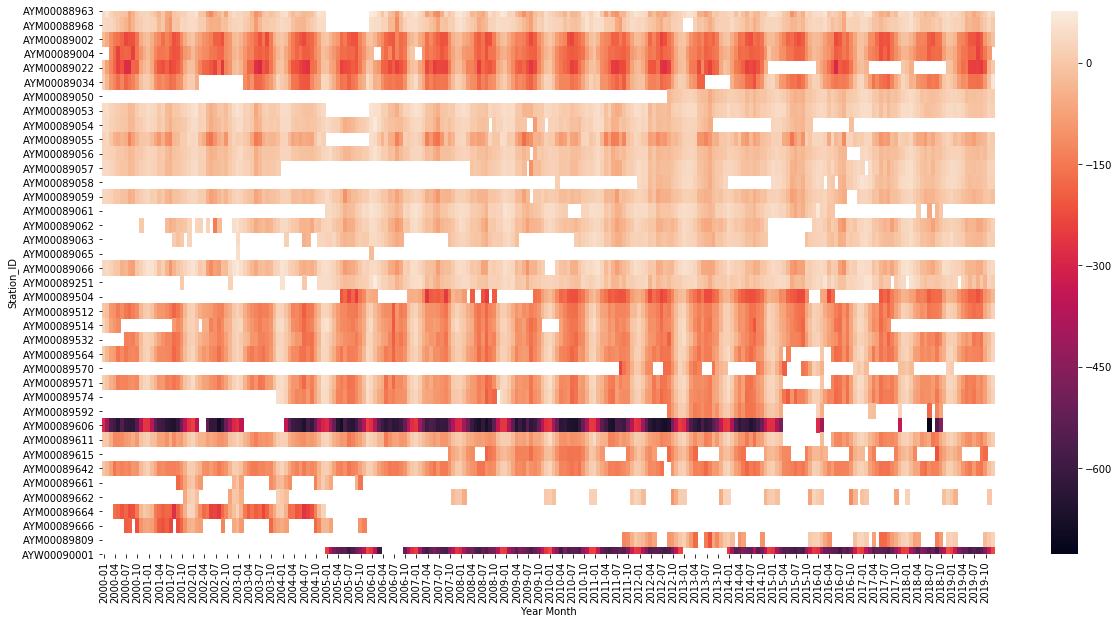

In [18]:
noaa_tmaxAYbymonthsid = noaa_tmaxAYhm.groupby(['Year Month', 'Station_ID'])['Data_Value'].mean()

# Pivot
noaa_tmaxAYbymonthsid = pd.DataFrame(noaa_tmaxAYbymonthsid).reset_index()
noaa_tmaxAYbymonthsidpivot = noaa_tmaxAYbymonthsid.pivot(index='Station_ID', columns='Year Month', values=['Data_Value'])
noaa_tmaxAYbymonthsidpivot.columns = noaa_tmaxAYbymonthsidpivot.columns.droplevel()
noaa_tmaxAYbymonthsidpivot.head(2)

# Plot
plt.figure(figsize=(20,10))
sns.heatmap(noaa_tmaxAYbymonthsidpivot);

Each row in this graph represents a specific station. Each column is a month starting January 2000 until October 2019.

At first glance, the light orange vertical bars can be observed, corresponding to the seasons that can also be characterized by temperatures i.e. hotter in the summer and coplder in the winter (although in this case, the temperatures are generally cold all year-round as this is in Antarctica).

Strikingly, there are two stations with very dark colors, translating to very cold temperatures. This may be a result of the stations' actual location e.g. nearest to the poles where there is very little sunlight, very short days, and therefore extremely cold weather.

## Predicting Extreme Temperatures

In predicting the maximum and minimum temperatures of Antarctica, we will be using Recurrent Neural Networks (RNN). A RNN is a neural network architecture that connects previous information together to understand the present. However, when information from longer periods of time in the past are required to forecast future values, RNNs become unstable. This is where LSTM comes in, a type of RNN known to perform way better than the standard RNN. LSTM is especially effective in these cases as it addresses the long-term dependency problem, which is very common in time series analysis. With this, LSTM finds many applications across varied areas of research and industries.

Several studies have been published recently which use LSTM in areas related to this study. Salman, et. al. (2018) built an adaptive statistical model for forecasting univariate weather variable [8]. Moreover, they explored the effect of intermediate variables to prediction accuracy when using a one-layer versus a multi-layer LSTM. The latter provided a higher accuracy, with pressure as the best intermediate variable.

In this study, we will be exploring one-layer and multi-layer LSTM approaches to create the model with the highest prediction accuracy.

In [39]:
# Save working dataframe to pickle file

# df_tmax
# with open('tmax.pickle', 'wb') as f:
#     pickle.dump(noaa_tmaxAY, f)
    
# df_tmin
# with open('tmin.pickle', 'wb') as f:
#     pickle.dump(noaa_tminAY, f)

### Temperature (Max)

In [3]:
# Load working dataframe from pickle file

# df_tmax
with open('tmax.pickle', 'rb') as f:
    df_tmax = pickle.load(f)
    
# df_tmin
# with open('tmin.pickle', 'rb') as f:
#     df_tmin = pickle.load(f)

In [75]:
# df_tmax = df_tmax.groupby(['Year', 'Month', 'Day'])['Data_Value'].mean().reset_index()

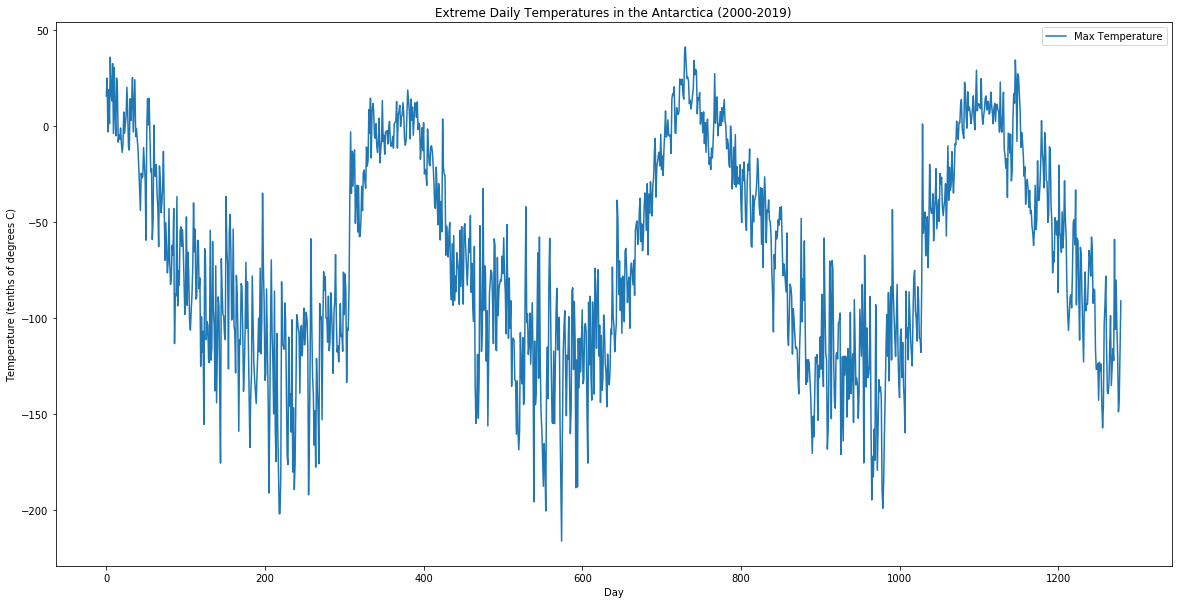

In [78]:
# plt.figure(figsize=(20,10))
# plt.title('Extreme Daily Temperatures in the Antarctica (2000-2019)')
# plt.plot(df_tmax['Data_Value'].index[:1280], df_tmax['Data_Value'].values[:1280], label='Max Temperature')
# # plt.plot(df_tmax['Data_Value'].index, noaa_tminAYbydate.values, label='Minimum Temperature')
# plt.xlabel('Day')
# plt.ylabel('Temperature (tenths of degrees C)')
# plt.legend();

In [4]:
# Converting to numpy array
df_tmax = df_tmax.groupby(['Year', 'Month', 'Day'])['Data_Value'].mean().reset_index().values
df_tmax

array([[ 2.00000000e+03,  1.00000000e+00,  1.00000000e+00,
         1.57272727e+01],
       [ 2.00000000e+03,  1.00000000e+00,  2.00000000e+00,
         2.49285714e+01],
       [ 2.00000000e+03,  1.00000000e+00,  3.00000000e+00,
        -3.17647059e+00],
       ...,
       [ 2.01900000e+03,  1.20000000e+01,  1.20000000e+01,
         1.14285714e+00],
       [ 2.01900000e+03,  1.20000000e+01,  1.30000000e+01,
        -5.71428571e-01],
       [ 2.01900000e+03,  1.20000000e+01,  1.40000000e+01,
        -6.94117647e+00]])

In [5]:
# Getting standard deviation of temperature (for calculating baseline error)
std = df_tmax.std(axis=0)
std[3] # 4th column (temperature in tenths of degrees C)

57.99621844732167

In [6]:
# Scaling the data
scaler = StandardScaler()
df_tmax = scaler.fit_transform(df_tmax)

In [7]:
df_tmax

array([[-1.64319504, -1.60059812, -1.66835513,  1.58167967],
       [-1.64319504, -1.60059812, -1.55486211,  1.74033309],
       [-1.64319504, -1.60059812, -1.4413691 ,  1.25573181],
       ...,
       [ 1.6613907 ,  1.5924759 , -0.41993197,  1.33020783],
       [ 1.6613907 ,  1.5924759 , -0.30643896,  1.30064926],
       [ 1.6613907 ,  1.5924759 , -0.19294595,  1.19081885]])

In [7]:
# Creating generator function, IMPORTANT: Change targets[j] index to the index of target
def generator(data, lookback, delay, min_index, max_index, target_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][target_index] # 3 because target is index 3
        yield samples, targets

In [8]:
# Preparing training, validation, test data 60/20/20 split

lookback = 30
step = 1
delay = 7
batch_size = 128 #Each of the batch will have inputs = lookback/step (240 hours in this example) +  delay/step (24 hours)  
target_index = 3

train_gen = generator(df_tmax,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=int(len(df_tmax)*0.6),
    target_index=3,
    shuffle=True,
    step=step,
    batch_size=batch_size)

val_gen = generator(df_tmax,
    lookback=lookback,
    delay=delay,
    min_index=int(len(df_tmax)*0.6 + 1),
    max_index=int(len(df_tmax)*0.6 + len(df_tmax)*0.2),
    target_index=3,
    step=step,
    batch_size=batch_size)

test_gen = generator(df_tmax,
    lookback=lookback,
    delay=delay,
    min_index=int(len(df_tmax)*0.6 + len(df_tmax)*0.2 + 1),
    max_index=None,
    target_index=3,
    step=step,
    batch_size=batch_size)

val_steps = int((len(df_tmax)*0.6 + len(df_tmax)*0.2) - (len(df_tmax)*0.6 + 1) - lookback)  #How many steps to draw from val_gen in order to see the entire 
                                          #validation set --- 
                                         #This is normally a problem in keras so let's manually set this to just 1000
test_steps = int(len(df_tmax) - (len(df_tmax)*0.6 + len(df_tmax)*0.2 + 1) - lookback)  #How many steps to draw from test_gen in order to see the 
                                          #entire test set 

In [9]:
# Setting baseline error
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return (np.mean(batch_maes))

baseline_error = evaluate_naive_method()
baseline_error

1.10678277560368

In [10]:
# Average absolute error
celsius_mae = baseline_error * std[3]
celsius_mae

64.18921562764403

### Setting Baseline Model: Simple Neural Networks

In [11]:
val_steps

1420

In [18]:
# Creating NN model
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df_tmax.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3872      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,905
Trainable params: 3,905
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Creating checkpoint
checkpoint = ModelCheckpoint("BaseSimpleNN.hdf5", monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto', period=1)

In [20]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=100, #ideally steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
                              epochs=50,
                              validation_data=val_gen, 
                              validation_steps=1000,
                              callbacks=[checkpoint]) #ideally validation_steps = TotalvalidationSamples / ValidationBatchSize

Epoch 1/50
100/100 [==============================] - 3s 32ms/step - loss: 0.4565 - val_loss: 0.6697
Epoch 2/50
100/100 [==============================] - 3s 30ms/step - loss: 0.3882 - val_loss: 0.5602
Epoch 3/50
100/100 [==============================] - 3s 30ms/step - loss: 0.3786 - val_loss: 0.2761
Epoch 4/50
100/100 [==============================] - 3s 31ms/step - loss: 0.3641 - val_loss: 0.4485
Epoch 5/50
100/100 [==============================] - 3s 30ms/step - loss: 0.3597 - val_loss: 0.4507
Epoch 6/50
100/100 [==============================] - 3s 30ms/step - loss: 0.3592 - val_loss: 0.2702
Epoch 7/50
100/100 [==============================] - 3s 29ms/step - loss: 0.3533 - val_loss: 0.5190
Epoch 8/50
100/100 [==============================] - 3s 30ms/step - loss: 0.3473 - val_loss: 0.3640
Epoch 9/50
100/100 [==============================] - 3s 30ms/step - loss: 0.3446 - val_loss: 0.3111
Epoch 10/50
100/100 [==============================] - 3s 30ms/step - loss: 0.3447 - val_lo

Let’s display the loss curves for validation and training.

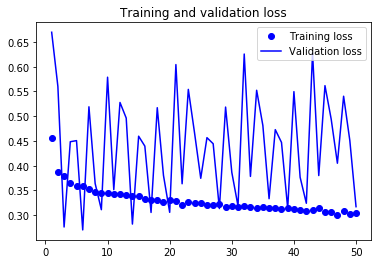

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Implementing 1-layer LSTM

In [30]:
# Creating LSTM model
model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, df_tmax.shape[-1]),
                      dropout=0.2, 
                      recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                4736      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Creating checkpoint
checkpoint = ModelCheckpoint("LSTM1layer.hdf5", monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto', period=1)

In [32]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=100, #ideally steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
                              epochs=50,
                              validation_data=val_gen, 
                              validation_steps=1000,
                              callbacks=[checkpoint]) #ideally validation_steps = TotalvalidationSamples / ValidationBatchSize

Epoch 1/50
100/100 [==============================] - 7s 66ms/step - loss: 0.5481 - val_loss: 0.5041
Epoch 2/50
100/100 [==============================] - 6s 62ms/step - loss: 0.4625 - val_loss: 0.2765
Epoch 3/50
100/100 [==============================] - 6s 61ms/step - loss: 0.4504 - val_loss: 0.4393
Epoch 4/50
100/100 [==============================] - 6s 60ms/step - loss: 0.4439 - val_loss: 0.3944
Epoch 5/50
100/100 [==============================] - 6s 60ms/step - loss: 0.4434 - val_loss: 0.2900
Epoch 6/50
100/100 [==============================] - 6s 60ms/step - loss: 0.4391 - val_loss: 0.5590
Epoch 7/50
100/100 [==============================] - 6s 61ms/step - loss: 0.4371 - val_loss: 0.3792
Epoch 8/50
100/100 [==============================] - 6s 60ms/step - loss: 0.4277 - val_loss: 0.4271
Epoch 9/50
100/100 [==============================] - 6s 61ms/step - loss: 0.4314 - val_loss: 0.5417
Epoch 10/50
100/100 [==============================] - 6s 61ms/step - loss: 0.4236 - val_lo

Let’s display the loss curves for validation and training.

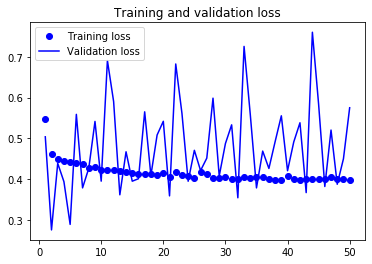

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Implementing 2-layer LSTM

In [34]:
# Creating LSTM model
model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, df_tmax.shape[-1]),
                      dropout=0.2, 
                      recurrent_dropout=0.5, 
                      return_sequences=True))
model.add(layers.LSTM(64, dropout=0.2, 
                      recurrent_dropout=0.5, 
                      activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, None, 32)          4736      
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 29,633
Trainable params: 29,633
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Creating checkpoint
checkpoint = ModelCheckpoint("LSTM2layer.hdf5", monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto', period=1)

In [36]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=100, #ideally steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
                              epochs=50,
                              validation_data=val_gen, 
                              validation_steps=1000,
                              callbacks=[checkpoint]) #ideally validation_steps = TotalvalidationSamples / ValidationBatchSize

Epoch 1/50
100/100 [==============================] - 15s 150ms/step - loss: 0.5318 - val_loss: 0.3568
Epoch 2/50
100/100 [==============================] - 14s 145ms/step - loss: 0.4759 - val_loss: 0.3936
Epoch 3/50
100/100 [==============================] - 15s 146ms/step - loss: 0.4602 - val_loss: 0.5335
Epoch 4/50
100/100 [==============================] - 15s 150ms/step - loss: 0.4567 - val_loss: 0.3549
Epoch 5/50
100/100 [==============================] - 15s 152ms/step - loss: 0.4503 - val_loss: 0.6096
Epoch 6/50
100/100 [==============================] - 16s 159ms/step - loss: 0.4417 - val_loss: 0.5032
Epoch 7/50
100/100 [==============================] - 15s 146ms/step - loss: 0.4363 - val_loss: 0.3268
Epoch 8/50
100/100 [==============================] - 14s 142ms/step - loss: 0.4390 - val_loss: 0.4363
Epoch 9/50
100/100 [==============================] - 14s 143ms/step - loss: 0.4369 - val_loss: 0.3790
Epoch 10/50
100/100 [==============================] - 14s 144ms/step - l

Let’s display the loss curves for validation and training.

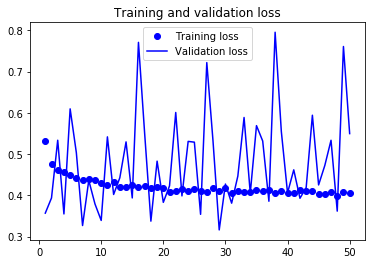

In [38]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Implementing 3-layer LSTM

In [39]:
# Creating LSTM model
model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, df_tmax.shape[-1]),
                      dropout=0.2, 
                      recurrent_dropout=0.5, 
                      return_sequences=True))
model.add(layers.LSTM(64, activation='relu', 
                      dropout=0.2, 
                      recurrent_dropout=0.5, 
                      return_sequences=True))
model.add(layers.LSTM(128, dropout=0.2, 
                      recurrent_dropout=0.5, 
                      activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, None, 32)          4736      
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 128,513
Trainable params: 128,513
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Creating checkpoint
checkpoint = ModelCheckpoint("LSTM3layer.hdf5", monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto', period=1)

In [41]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=100, #ideally steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
                              epochs=50,
                              validation_data=val_gen, 
                              validation_steps=1000,
                              callbacks=[checkpoint]) #ideally validation_steps = TotalvalidationSamples / ValidationBatchSize

Epoch 1/50
100/100 [==============================] - 31s 311ms/step - loss: 0.5656 - val_loss: 0.2541
Epoch 2/50
100/100 [==============================] - 32s 324ms/step - loss: 0.4844 - val_loss: 0.4429
Epoch 3/50
100/100 [==============================] - 34s 344ms/step - loss: 0.4692 - val_loss: 0.4167
Epoch 4/50
100/100 [==============================] - 34s 344ms/step - loss: 0.4596 - val_loss: 0.2206
Epoch 5/50
100/100 [==============================] - 35s 349ms/step - loss: 0.4547 - val_loss: 0.5031
Epoch 6/50
100/100 [==============================] - 36s 357ms/step - loss: 0.4466 - val_loss: 0.4248
Epoch 7/50
100/100 [==============================] - 34s 343ms/step - loss: 0.4403 - val_loss: 0.4212
Epoch 8/50
100/100 [==============================] - 35s 347ms/step - loss: 0.4376 - val_loss: 0.5398
Epoch 9/50
100/100 [==============================] - 35s 345ms/step - loss: 0.4397 - val_loss: 0.3388
Epoch 10/50
100/100 [==============================] - 34s 343ms/step - l

Let’s display the loss curves for validation and training.

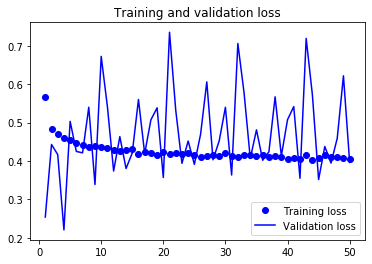

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predicting on Test Data using 3-layer LSTM

In [12]:
# loading best model weights

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Recreating 3-layer LSTM best model
model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, df_tmax.shape[-1]),
                      dropout=0.2, 
                      recurrent_dropout=0.5, 
                      return_sequences=True))
model.add(layers.LSTM(64, activation='relu', 
                      dropout=0.2, 
                      recurrent_dropout=0.5, 
                      return_sequences=True))
model.add(layers.LSTM(128, dropout=0.2, 
                      recurrent_dropout=0.5, 
                      activation='relu'))
model.add(layers.Dense(1))
model.summary()

# load weights
model.load_weights("LSTM3layer.hdf5")

# Compile model (required to make predictions)
model.compile(optimizer=RMSprop(), loss='mae')
print("Created model and loaded weights from file")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 32)          4736      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 128,513
Trainable params: 128,513
Non-trainable params: 0
_________________________________________________________________
Created model and loaded weights from file


In [13]:
traing = []
for i in range(1000):
    traing.append(next(train_gen))

vg = []
for i in range(1000):
    vg.append(next(val_gen))
    
testg = []
for i in range(1000):
    testg.append(next(test_gen))

Familiarizing with inputs, outputs of the NN.

In [14]:
vg[0][0].shape # (batch_size, lookback, no. of features)

(128, 30, 4)

In [15]:
vg[999][0].shape # (batch_size, lookback, no. of features)

(128, 30, 4)

In [16]:
vg[999][1].shape # (target,)

(128,)

In [17]:
df_tmax.shape  # (total data points, no. of features)

(7255, 4)

Running the actual prediction and then plotting the results.

In [18]:
# Predicting the next 1280 days (3.51 years)
preds_test = np.array([])
targets_test = np.array([])
for v in testg[:10]:
    preds_test = np.append(preds_test, model.predict(v[0]))
    targets_test = np.append(targets_test, v[1])

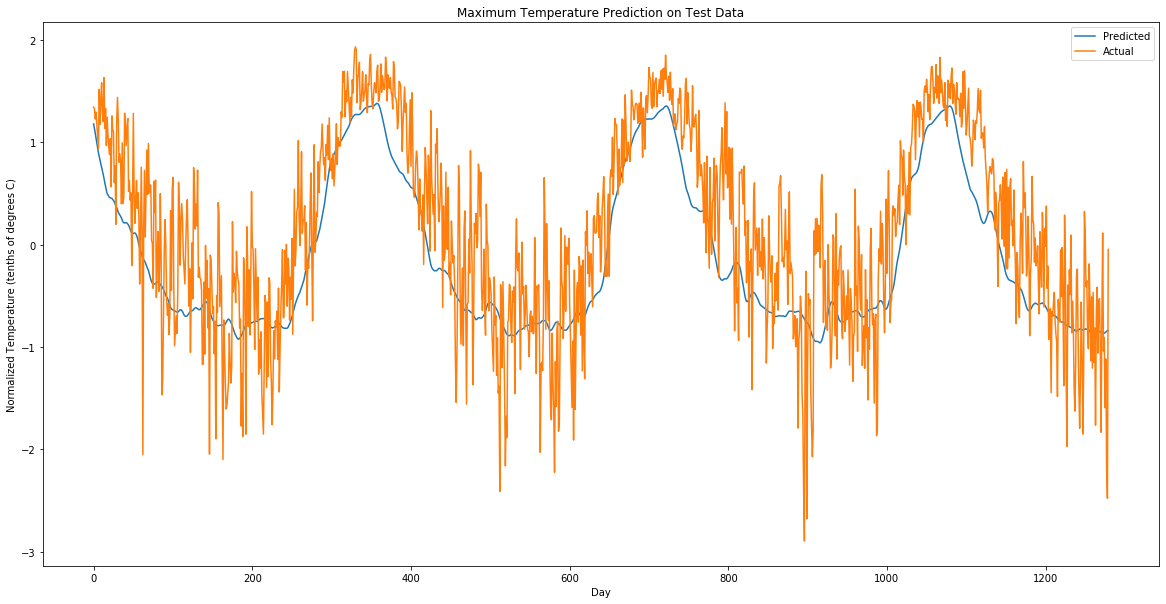

In [27]:
plt.figure(figsize=(20,10))
plt.plot(preds_test, label='Predicted')
plt.plot(targets_test, label='Actual')
plt.xlabel('Day')
plt.ylabel('Normalized Temperature (tenths of degrees C)')
plt.title('Maximum Temperature Prediction on Test Data')
plt.legend()

--------------------

### Temperature (Min)

In [37]:
# Load working dataframe from pickle file

# df_tmax
# with open('tmax.pickle', 'rb') as f:
#     df_tmax = pickle.load(f)
    
# df_tmin
with open('tmin.pickle', 'rb') as f:
    df_tmin = pickle.load(f)

In [3]:
# df_tmin = df_tmin.groupby(['Year', 'Month', 'Day'])['Data_Value'].mean().reset_index()

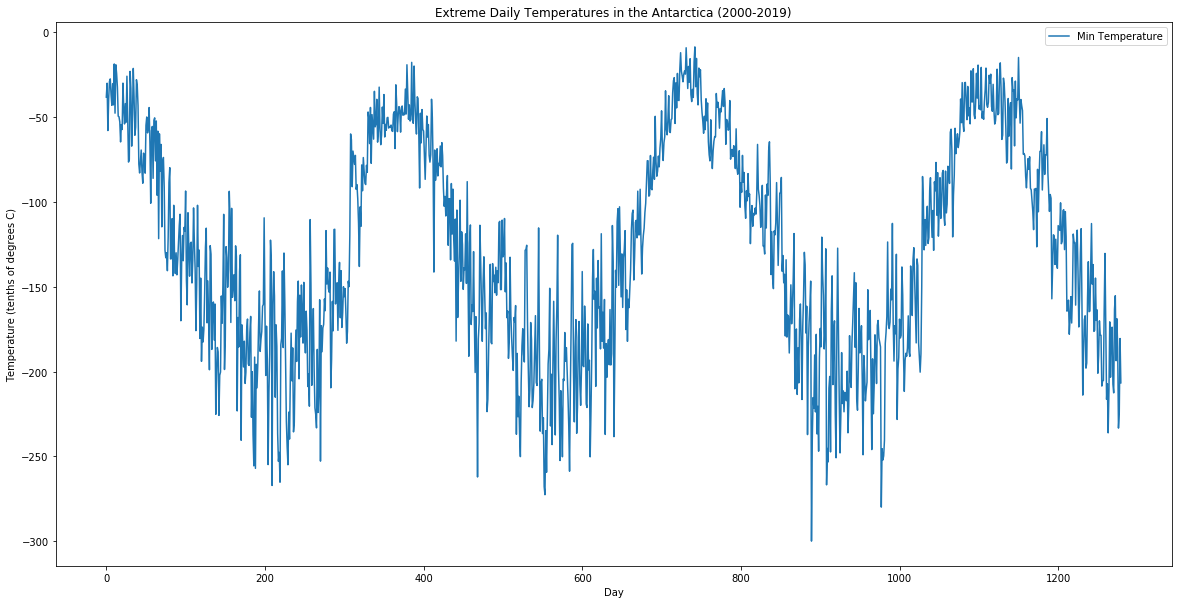

In [4]:
# plt.figure(figsize=(20,10))
# plt.title('Extreme Daily Temperatures in the Antarctica (2000-2019)')
# plt.plot(df_tmin['Data_Value'].index[:1280], df_tmin['Data_Value'].values[:1280], label='Min Temperature')
# # plt.plot(df_tmax['Data_Value'].index, noaa_tminAYbydate.values, label='Minimum Temperature')
# plt.xlabel('Day')
# plt.ylabel('Temperature (tenths of degrees C)')
# plt.legend();

In [38]:
# Converting to numpy array
df_tmin = df_tmin.groupby(['Year', 'Month', 'Day'])['Data_Value'].mean().reset_index().values
df_tmin

array([[ 2.00000000e+03,  1.00000000e+00,  1.00000000e+00,
        -3.82000000e+01],
       [ 2.00000000e+03,  1.00000000e+00,  2.00000000e+00,
        -3.00000000e+01],
       [ 2.00000000e+03,  1.00000000e+00,  3.00000000e+00,
        -5.78888889e+01],
       ...,
       [ 2.01900000e+03,  1.20000000e+01,  1.20000000e+01,
        -6.22083333e+01],
       [ 2.01900000e+03,  1.20000000e+01,  1.30000000e+01,
        -4.33750000e+01],
       [ 2.01900000e+03,  1.20000000e+01,  1.40000000e+01,
        -6.00434783e+01]])

In [39]:
# Getting standard deviation of temperature (for calculating baseline error)
std = df_tmin.std(axis=0)
std[3] # 4th column (temperature in tenths of degrees C)

66.12859916460813

In [40]:
# Scaling the data
scaler = StandardScaler()
df_tmin = scaler.fit_transform(df_tmin)

In [41]:
df_tmin

array([[-1.64322909, -1.60074735, -1.66843848,  1.51719838],
       [-1.64322909, -1.60074735, -1.55495288,  1.64119919],
       [-1.64322909, -1.60074735, -1.44146728,  1.21946201],
       ...,
       [ 1.66154312,  1.59250577, -0.42009691,  1.15414315],
       [ 1.66154312,  1.59250577, -0.30661131,  1.43894177],
       [ 1.66154312,  1.59250577, -0.19312571,  1.1868802 ]])

In [42]:
# Creating generator function, IMPORTANT: Change targets[j] index to the index of target
def generator(data, lookback, delay, min_index, max_index, target_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][target_index] # 3 because target is index 3
        yield samples, targets

In [43]:
# Preparing training, validation, test data 60/20/20 split

lookback = 30
step = 1
delay = 7
batch_size = 128 #Each of the batch will have inputs = lookback/step (240 hours in this example) +  delay/step (24 hours)  
target_index = 3

train_gen = generator(df_tmin,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=int(len(df_tmin)*0.6),
    target_index=3,
    shuffle=True,
    step=step,
    batch_size=batch_size)

val_gen = generator(df_tmin,
    lookback=lookback,
    delay=delay,
    min_index=int(len(df_tmin)*0.6 + 1),
    max_index=int(len(df_tmin)*0.6 + len(df_tmin)*0.2),
    target_index=3,
    step=step,
    batch_size=batch_size)

test_gen = generator(df_tmin,
    lookback=lookback,
    delay=delay,
    min_index=int(len(df_tmin)*0.6 + len(df_tmin)*0.2 + 1),
    max_index=None,
    target_index=3,
    step=step,
    batch_size=batch_size)

val_steps = int((len(df_tmin)*0.6 + len(df_tmin)*0.2) - (len(df_tmin)*0.6 + 1) - lookback)  #How many steps to draw from val_gen in order to see the entire 
                                          #validation set --- 
                                         #This is normally a problem in keras so let's manually set this to just 1000
test_steps = int(len(df_tmin) - (len(df_tmin)*0.6 + len(df_tmin)*0.2 + 1) - lookback)  #How many steps to draw from test_gen in order to see the 
                                          #entire test set 

In [44]:
# Setting baseline error
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return (np.mean(batch_maes))

baseline_error = evaluate_naive_method()
baseline_error

1.1597947393784673

In [45]:
# Average absolute error
celsius_mae = baseline_error * std[3]
celsius_mae

76.69560143357982

### Setting Baseline Model: Simple Neural Networks

In [14]:
val_steps

1420

In [15]:
# Creating NN model
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df_tmin.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3872      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,905
Trainable params: 3,905
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Creating checkpoint
checkpoint = ModelCheckpoint("BaseSimpleNNMin.hdf5", monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto', period=1)

In [17]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=100, #ideally steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
                              epochs=50,
                              validation_data=val_gen, 
                              validation_steps=1000,
                              callbacks=[checkpoint]) #ideally validation_steps = TotalvalidationSamples / ValidationBatchSize

Epoch 1/50
100/100 [==============================] - 3s 31ms/step - loss: 0.4692 - val_loss: 0.5646
Epoch 2/50
100/100 [==============================] - 3s 31ms/step - loss: 0.3838 - val_loss: 0.4507
Epoch 3/50
100/100 [==============================] - 3s 31ms/step - loss: 0.3667 - val_loss: 0.2919
Epoch 4/50
100/100 [==============================] - 3s 31ms/step - loss: 0.3567 - val_loss: 0.4751
Epoch 5/50
100/100 [==============================] - 3s 31ms/step - loss: 0.3503 - val_loss: 0.4507
Epoch 6/50
100/100 [==============================] - 3s 33ms/step - loss: 0.3476 - val_loss: 0.2694
Epoch 7/50
100/100 [==============================] - 4s 37ms/step - loss: 0.3422 - val_loss: 0.4725
Epoch 8/50
100/100 [==============================] - 4s 37ms/step - loss: 0.3443 - val_loss: 0.3738
Epoch 9/50
100/100 [==============================] - 4s 43ms/step - loss: 0.3416 - val_loss: 0.2729
Epoch 10/50
100/100 [==============================] - 4s 38ms/step - loss: 0.3374 - val_lo

Let’s display the loss curves for validation and training.

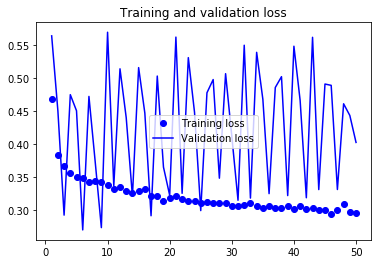

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Implementing 1-layer LSTM

In [19]:
# Creating LSTM model
model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, df_tmin.shape[-1]),
                      dropout=0.2, 
                      recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4736      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Creating checkpoint
checkpoint = ModelCheckpoint("LSTM1layerMin.hdf5", monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto', period=1)

In [21]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=100, #ideally steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
                              epochs=50,
                              validation_data=val_gen, 
                              validation_steps=1000,
                              callbacks=[checkpoint]) #ideally validation_steps = TotalvalidationSamples / ValidationBatchSize

Epoch 1/50
100/100 [==============================] - 9s 87ms/step - loss: 0.5077 - val_loss: 0.2556
Epoch 2/50
100/100 [==============================] - 8s 83ms/step - loss: 0.4545 - val_loss: 0.4536
Epoch 3/50
100/100 [==============================] - 8s 82ms/step - loss: 0.4438 - val_loss: 0.3835
Epoch 4/50
100/100 [==============================] - 8s 83ms/step - loss: 0.4370 - val_loss: 0.3189
Epoch 5/50
100/100 [==============================] - 8s 82ms/step - loss: 0.4356 - val_loss: 0.5030
Epoch 6/50
100/100 [==============================] - 9s 93ms/step - loss: 0.4196 - val_loss: 0.3106
Epoch 7/50
100/100 [==============================] - 9s 91ms/step - loss: 0.4221 - val_loss: 0.4811
Epoch 8/50
100/100 [==============================] - 9s 92ms/step - loss: 0.4231 - val_loss: 0.3935
Epoch 9/50
100/100 [==============================] - 9s 89ms/step - loss: 0.4165 - val_loss: 0.2902
Epoch 10/50
100/100 [==============================] - 9s 90ms/step - loss: 0.4080 - val_lo

Let’s display the loss curves for validation and training.

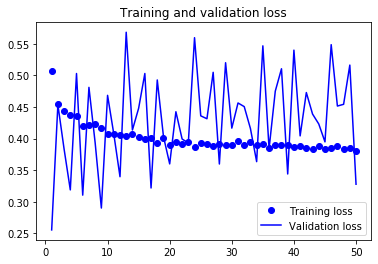

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Implementing 2-layer LSTM

In [23]:
# Creating LSTM model
model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, df_tmin.shape[-1]),
                      dropout=0.2, 
                      recurrent_dropout=0.5, 
                      return_sequences=True))
model.add(layers.LSTM(64, dropout=0.2, 
                      recurrent_dropout=0.5, 
                      activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 32)          4736      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 29,633
Trainable params: 29,633
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Creating checkpoint
checkpoint = ModelCheckpoint("LSTM2layerMin.hdf5", monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto', period=1)

In [25]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=100, #ideally steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
                              epochs=50,
                              validation_data=val_gen, 
                              validation_steps=1000,
                              callbacks=[checkpoint]) #ideally validation_steps = TotalvalidationSamples / ValidationBatchSize

Epoch 1/50
100/100 [==============================] - 15s 155ms/step - loss: 0.5264 - val_loss: 0.5168
Epoch 2/50
100/100 [==============================] - 15s 151ms/step - loss: 0.4650 - val_loss: 0.3864
Epoch 3/50
100/100 [==============================] - 15s 149ms/step - loss: 0.4560 - val_loss: 0.3434
Epoch 4/50
100/100 [==============================] - 15s 147ms/step - loss: 0.4460 - val_loss: 0.4192
Epoch 5/50
100/100 [==============================] - 15s 147ms/step - loss: 0.4345 - val_loss: 0.4336
Epoch 6/50
100/100 [==============================] - 15s 147ms/step - loss: 0.4333 - val_loss: 0.2776
Epoch 7/50
100/100 [==============================] - 15s 148ms/step - loss: 0.4298 - val_loss: 0.5266
Epoch 8/50
100/100 [==============================] - 14s 145ms/step - loss: 0.4262 - val_loss: 0.4441
Epoch 9/50
100/100 [==============================] - 14s 142ms/step - loss: 0.4263 - val_loss: 0.3859
Epoch 10/50
100/100 [==============================] - 15s 149ms/step - l

Let’s display the loss curves for validation and training.

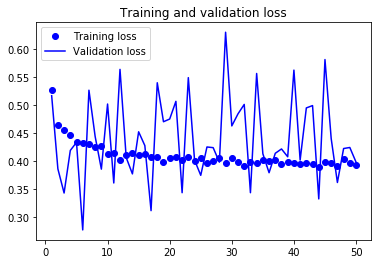

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Implementing 3-layer LSTM

In [27]:
# Creating LSTM model
model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, df_tmin.shape[-1]),
                      dropout=0.2, 
                      recurrent_dropout=0.5, 
                      return_sequences=True))
model.add(layers.LSTM(64, activation='relu', 
                      dropout=0.2, 
                      recurrent_dropout=0.5, 
                      return_sequences=True))
model.add(layers.LSTM(128, dropout=0.2, 
                      recurrent_dropout=0.5, 
                      activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 32)          4736      
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 128,513
Trainable params: 128,513
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Creating checkpoint
checkpoint = ModelCheckpoint("LSTM3layerMin.hdf5", monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto', period=1)

In [29]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=100, #ideally steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
                              epochs=50,
                              validation_data=val_gen, 
                              validation_steps=1000,
                              callbacks=[checkpoint]) #ideally validation_steps = TotalvalidationSamples / ValidationBatchSize

Epoch 1/50
100/100 [==============================] - 45s 448ms/step - loss: 0.5389 - val_loss: 0.4213
Epoch 2/50
100/100 [==============================] - 44s 441ms/step - loss: 0.4673 - val_loss: 0.4113
Epoch 3/50
100/100 [==============================] - 44s 444ms/step - loss: 0.4576 - val_loss: 0.3608
Epoch 4/50
100/100 [==============================] - 44s 444ms/step - loss: 0.4472 - val_loss: 0.5132
Epoch 5/50
100/100 [==============================] - 45s 445ms/step - loss: 0.4356 - val_loss: 0.3263
Epoch 6/50
100/100 [==============================] - 45s 448ms/step - loss: 0.4310 - val_loss: 0.5385
Epoch 7/50
100/100 [==============================] - 44s 441ms/step - loss: 0.4298 - val_loss: 0.4102
Epoch 8/50
100/100 [==============================] - 44s 441ms/step - loss: 0.4256 - val_loss: 0.3715
Epoch 9/50
100/100 [==============================] - 45s 445ms/step - loss: 0.4119 - val_loss: 0.4210
Epoch 10/50
100/100 [==============================] - 44s 441ms/step - l

Let’s display the loss curves for validation and training.

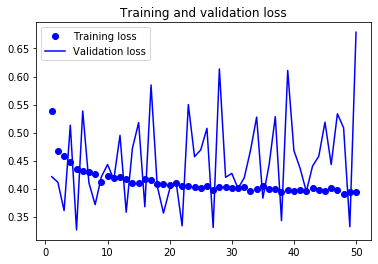

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predicting on Test Data using 3-layer LSTM

In [46]:
# loading best model weights

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Recreating 1-layer LSTM best model
model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, df_tmin.shape[-1]),
                      dropout=0.2, 
                      recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()

# load weights
model.load_weights("LSTM1layerMin.hdf5")

# Compile model (required to make predictions)
model.compile(optimizer=RMSprop(), loss='mae')
print("Created model and loaded weights from file")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                4736      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________
Created model and loaded weights from file


In [47]:
traing = []
for i in range(1000):
    traing.append(next(train_gen))

vg = []
for i in range(1000):
    vg.append(next(val_gen))
    
testg = []
for i in range(1000):
    testg.append(next(test_gen))

Familiarizing with inputs, outputs of the NN.

In [33]:
vg[0][0].shape # (batch_size, lookback, no. of features)

(128, 30, 4)

In [34]:
vg[999][0].shape # (batch_size, lookback, no. of features)

(128, 30, 4)

In [35]:
vg[999][1].shape # (target,)

(128,)

In [36]:
df_tmin.shape  # (total data points, no. of features)

(7256, 4)

In [37]:
len(testg)

1000

Running the actual prediction and then plotting the results.

In [48]:
# Predicting the next 1280 days (3.51 years)
preds_test = np.array([])
targets_test = np.array([])
for v in testg[:10]:
    preds_test = np.append(preds_test, model.predict(v[0]))
    targets_test = np.append(targets_test, v[1])

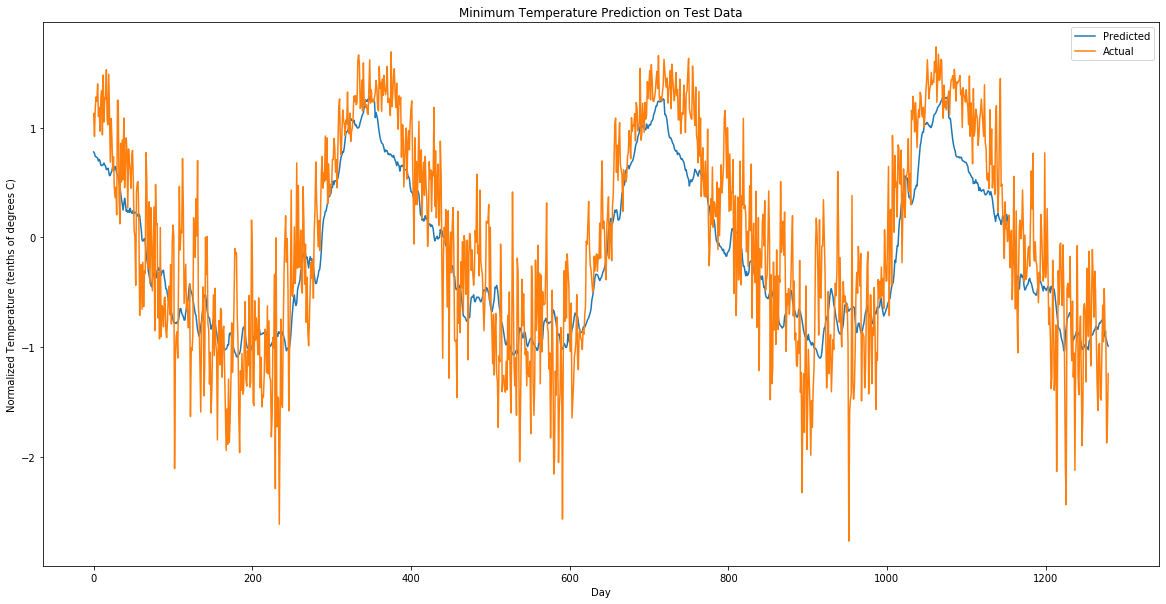

In [49]:
plt.figure(figsize=(20,10))
plt.plot(preds_test, label='Predicted')
plt.plot(targets_test, label='Actual')
plt.xlabel('Day')
plt.ylabel('Normalized Temperature (tenths of degrees C)')
plt.title('Minimum Temperature Prediction on Test Data')
plt.legend()

## References

(NCEI), N. (2019). Global Historical Climatology Network - Daily (GHCN-Daily), Version 3. Data.nodc.noaa.gov. Available at: https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc%3AC00861&fbclid=IwAR0GHgz0kQFfGrnVxt_gk0zmaz4LKB6ohpi-9XYEWGJCvYnP0OWRASUIEI4

Medium. (2019). Fun with GHCN Data on Google’s BigQuery…. Available at: https://medium.com/google-cloud/fun-with-ghcn-data-on-googles-bigquery-79275af13e07

Amazon Web Services. (2019). Visualize over 200 years of global climate data using Amazon Athena and Amazon QuickSight | Amazon Web Services. Available at: https://aws.amazon.com/blogs/big-data/visualize-over-200-years-of-global-climate-data-using-amazon-athena-and-amazon-quicksight/?fbclid=IwAR0LihjOl3FXWqJzsm2zUTCXfLNXJkcebtd4YZwWP0tZaUH7LY11wkWAEjM

NOAA Global Historical Climatology Network Daily (GHCN-D) Available at: https://registry.opendata.aws/noaa-ghcn/

## Acknowledgment

We would like to acknowledge Gilbert Chua and Benj Danao for their contribution in the completion of this technical report.